In [1]:
# import packages 
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy.stats import mannwhitneyu ,chi2_contingency, anderson, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from jenkspy import JenksNaturalBreaks
import warnings
warnings.filterwarnings("ignore")


from src.preprocessing import convert_numeric_to_category, DecisionTreeDiscretizer
from src.tests import cramers_v, mannwhitney_test, calculate_information_value_from_contingency_table, show_conditionnal_density, show_risk_stability_overtime, show_volume_stability_overtime
from src.score import grid_score, attribute_score, subplot_segment_default_rate
print("Importation de packages terminée")

Importation de packages terminée


In [2]:

data=pd.read_csv("data/application_train_vf.csv",parse_dates=["date_mensuelle"], index_col=0)
data["SK_ID_CURR"].value_counts().max()

# importation de données d'autre base préparées
credit_bureau_data=pd.read_csv("data/cb_findings.csv", index_col=0)
data=data.merge(credit_bureau_data, left_on="SK_ID_CURR", right_on="CB_SK_ID_CURR")

# feature engineering
data["HAS_CHILDREN"]=data["CNT_CHILDREN"].apply(lambda x : "Y" if x > 0 else "N")
data.drop(columns=["CNT_CHILDREN"], inplace=True)

drop_documents_cols=["FLAG_DOCUMENT_2","FLAG_DOCUMENT_3","FLAG_DOCUMENT_4" , 
"FLAG_DOCUMENT_5" , "FLAG_DOCUMENT_6","FLAG_DOCUMENT_7" ,              
"FLAG_DOCUMENT_8" , "FLAG_DOCUMENT_9","FLAG_DOCUMENT_10"  ,"FLAG_DOCUMENT_11" , "FLAG_DOCUMENT_12",              
"FLAG_DOCUMENT_13" ,"FLAG_DOCUMENT_14" ,"FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16" ,
"FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18","FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20","FLAG_DOCUMENT_21"]

data.drop(columns=drop_documents_cols, inplace=True)


convert_numeric_to_category(data)

data["date_annee"]=data["date_mensuelle"].dt.year #annee

out_of_sample_data=data[data["date_annee"]==2020] # echantillon out-of-sample
data=data[data["date_annee"]<2020] # echantillon in-sample


In [3]:
categorical_vars=data.select_dtypes(include="object").columns.tolist()
numerical_vars=data.select_dtypes(include="number").columns.tolist()
binary_vars=[var for var in numerical_vars if (data[var].nunique()==2)&(var !="TARGET")]

binary_risk_non_stable_vars=["FLAG_MOBIL", "FLAG_CONT_MOBILE", "FLAG_EMAIL", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION","LIVE_REGION_NOT_WORK_REGION"]

binary_vars=list(filter(lambda x : x not in binary_risk_non_stable_vars, binary_vars))

binary_volume_non_stable_vars=[]

# variables à virer parmi les binaires:
binary_non_stable_vars=list(set(binary_volume_non_stable_vars+binary_risk_non_stable_vars))

binary_vars=list(filter(lambda x : x not in binary_non_stable_vars,binary_vars))

data.drop(columns=binary_non_stable_vars, inplace=True)

numerical_vars=list(filter(lambda x : x not in binary_vars+binary_non_stable_vars,numerical_vars))

low_category_categorical_vars=[var for var in categorical_vars+numerical_vars if  (var not in binary_vars+binary_non_stable_vars+["TARGET"]) & (data[var].nunique()>=2) & (data[var].nunique()<=4)]
    
    
low_category_non_stable_vars=["FLAG_OWN_REALTY", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "EMERGENCYSTATE_MODE", "CODE_GENDER"]
low_category_categorical_vars=list(filter(lambda x : x not in low_category_non_stable_vars,low_category_categorical_vars))

data.drop(columns=low_category_non_stable_vars)

categorical_vars=list(filter(lambda x : x not in binary_non_stable_vars+binary_vars+low_category_categorical_vars+low_category_non_stable_vars, categorical_vars))

    
data["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
out_of_sample_data["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)

# groupement proposé pour occupation_type suivant tdf
group_occupation_type={
    0: ['Accountants', 'HR staff', 'High skill tech staff'],
 1: ['Managers', 'Core staff', 'Private service staff', 'Unknown',
        'Medicine staff', 'IT staff', 'Secretaries'],
 2: ['Realty agents', 'Cleaning staff', 'Sales staff', 'Laborers',
        'Cooking staff', 'Security staff'],
 3: ['Drivers', 'Waiters/barmen staff', 'Low-skill Laborers'],
}

data["OCCUPATION_TYPE"]=data["OCCUPATION_TYPE"].map({value: key for key, values in group_occupation_type.items() for value in values})
out_of_sample_data["OCCUPATION_TYPE"]=out_of_sample_data["OCCUPATION_TYPE"].map({value: key for key, values in group_occupation_type.items() for value in values})
group_education_type={
    "Graduated" : ["Academic degree", "Higher education"],
    "Non graduated":["Lower secondary", "Secondary / secondary special", "Incomplete higher"]
}

data["NAME_EDUCATION_TYPE"]=data["NAME_EDUCATION_TYPE"].map({value: key for key, values in group_education_type.items() for value in values})
out_of_sample_data["NAME_EDUCATION_TYPE"]=out_of_sample_data["NAME_EDUCATION_TYPE"].map({value: key for key, values in group_education_type.items() for value in values})

group_family_status={
    "Already_Married": ["Civil marriage", "Married","Separated", "Widow"],
    "Single" :["Single / not married", "Unknown"]
}

data["NAME_FAMILY_STATUS_2"]=data["NAME_FAMILY_STATUS"].map({value: key for key, values in group_family_status.items() for value in values})
out_of_sample_data["NAME_FAMILY_STATUS_2"]=out_of_sample_data["NAME_FAMILY_STATUS"].map({value: key for key, values in group_family_status.items() for value in values})


data["FAM_STATS_CHILD"]=data["NAME_FAMILY_STATUS_2"]+"-"+"HAS_CHILDREN_"+data["HAS_CHILDREN"] 

data["FAM_STATS_CHILD"]=data["FAM_STATS_CHILD"].apply(lambda x : "Single" if x in ["Single-HAS_CHILDREN_N","Single-HAS_CHILDREN_Y"] else x)
out_of_sample_data["FAM_STATS_CHILD"]=out_of_sample_data["NAME_FAMILY_STATUS_2"]+"-"+"HAS_CHILDREN_"+out_of_sample_data["HAS_CHILDREN"] 

out_of_sample_data["FAM_STATS_CHILD"]=out_of_sample_data["FAM_STATS_CHILD"].apply(lambda x : "Single" if x in ["Single-HAS_CHILDREN_N","Single-HAS_CHILDREN_Y"] else x)



social_vars=["OBS_30_CNT_SOCIAL_CIRCLE",
"DEF_30_CNT_SOCIAL_CIRCLE",
"OBS_60_CNT_SOCIAL_CIRCLE",
"DEF_60_CNT_SOCIAL_CIRCLE", "DAYS_LAST_PHONE_CHANGE"
]

    
data["DAYS_LAST_PHONE_CHANGE"].fillna(data["DAYS_LAST_PHONE_CHANGE"].min(), inplace=True)
out_of_sample_data["DAYS_LAST_PHONE_CHANGE"].fillna(out_of_sample_data["DAYS_LAST_PHONE_CHANGE"].min(), inplace=True)

data["AMT_CREDIT_TO_INCOME"]=(data["AMT_CREDIT"]+data["CB_AMT_CREDIT_SUM"])/data["AMT_INCOME_TOTAL"]
out_of_sample_data["AMT_CREDIT_TO_INCOME"]=(out_of_sample_data["AMT_CREDIT"]+out_of_sample_data["CB_AMT_CREDIT_SUM"])/out_of_sample_data["AMT_INCOME_TOTAL"]

median_imputer=SimpleImputer(strategy="median").set_output(transform="pandas")
data["AMT_GOODS_PRICE"]=median_imputer.fit_transform(data["AMT_GOODS_PRICE"].to_numpy().reshape(-1,1))
out_of_sample_data["AMT_GOODS_PRICE"]=median_imputer.fit_transform(out_of_sample_data["AMT_GOODS_PRICE"].to_numpy().reshape(-1,1))

# FEATURE ENGINEERING
data["AMT_CREDIT_NORM"]=data["AMT_CREDIT"]/data["AMT_GOODS_PRICE"]
data["AMT_ANNUITY"]=(data["AMT_ANNUITY"]+data["CB_AMT_ANNUITY"])/data["AMT_INCOME_TOTAL"]
data["AMT_INCOME_TOTAL_NORM"]=data["AMT_INCOME_TOTAL"]/data["AMT_GOODS_PRICE"]

data["BORROWER_AGE"]=data["DAYS_BIRTH"].apply(np.abs)//365
data["BORROWER_SENIORITY"]=data["DAYS_EMPLOYED"].apply(np.abs)//365
data["BORROWER_FIDELITY"]=data["DAYS_REGISTRATION"].apply(np.abs)//365

out_of_sample_data["AMT_CREDIT_NORM"]=out_of_sample_data["AMT_CREDIT"]/out_of_sample_data["AMT_GOODS_PRICE"]
out_of_sample_data["AMT_ANNUITY"]=(out_of_sample_data["AMT_ANNUITY"]+out_of_sample_data["CB_AMT_ANNUITY"])/out_of_sample_data["AMT_INCOME_TOTAL"]
out_of_sample_data["AMT_INCOME_TOTAL_NORM"]=out_of_sample_data["AMT_INCOME_TOTAL"]/out_of_sample_data["AMT_GOODS_PRICE"]

out_of_sample_data["BORROWER_AGE"]=out_of_sample_data["DAYS_BIRTH"].apply(np.abs)//365
out_of_sample_data["BORROWER_SENIORITY"]=out_of_sample_data["DAYS_EMPLOYED"].apply(np.abs)//365
out_of_sample_data["BORROWER_FIDELITY"]=out_of_sample_data["DAYS_REGISTRATION"].apply(np.abs)//365

    
    
tested_numerical_variables=[
    "BORROWER_AGE","BORROWER_SENIORITY","BORROWER_FIDELITY","AMT_INCOME_TOTAL_NORM",
    "AMT_CREDIT_NORM", "AMT_INCOME_TOTAL","AMT_CREDIT",
    "AMT_ANNUITY","AMT_GOODS_PRICE",
    'CB_AMT_CREDIT_SUM_DEBT', 'CB_NB_CREDIT_ACTIVE', 'CB_NB_CREDIT_CLOSED', 'CB_DAYS_CREDIT', 'CB_DAYS_CREDIT_ENDDATE', 'CB_AMT_CREDIT_SUM', 'CB_AMT_ANNUITY'
] 

    
    
# echantillon d'entrainement et echantillon de calibrage
data_train, data_test=train_test_split(data, test_size=0.3, stratify=data["TARGET"], random_state=42)

discretised_cols=["AMT_INCOME_TOTAL_NORM", "AMT_CREDIT_TO_INCOME" , "BORROWER_AGE", "BORROWER_SENIORITY",
                  "BORROWER_FIDELITY", "AMT_CREDIT_NORM", "DAYS_LAST_PHONE_CHANGE"
                  ]
discretised_cols_2=["AMT_ANNUITY","AMT_GOODS_PRICE", "CB_DAYS_CREDIT",
                  'CB_AMT_CREDIT_SUM_DEBT', 'CB_NB_CREDIT_CLOSED', 
                  'CB_DAYS_CREDIT_ENDDATE', 'CB_AMT_CREDIT_SUM', 'CB_AMT_ANNUITY'
]

dt_discretizer=DecisionTreeDiscretizer(target=data_train["TARGET"]) #instanciation du discrétiseur

for col in discretised_cols:
    dt_discretizer.fit(data_train[col])
    data_train[col]=dt_discretizer.transform(data_train[col])
    data_test[col]=dt_discretizer.transform(data_test[col])
    out_of_sample_data[col]=dt_discretizer.transform(out_of_sample_data[col])

    

for col in discretised_cols_2:
    dt_discretizer.fit(data_train[col])
    data_train[col]=dt_discretizer.transform(data_train[col])
    data_test[col]=dt_discretizer.transform(data_test[col])
    out_of_sample_data[col]=dt_discretizer.transform(out_of_sample_data[col])
    
        
# Modélisation 
print("Phase de modélisation")
formula="TARGET ~ C(OCCUPATION_TYPE,Treatment(reference=0)) + C(NAME_EDUCATION_TYPE,Treatment(reference='Non graduated'))  + C(AMT_CREDIT_NORM,Treatment(reference=3)) + C(BORROWER_AGE,Treatment(reference=0)) + C(BORROWER_SENIORITY,Treatment(reference=0)) + C(CB_NB_CREDIT_CLOSED, Treatment(reference=0))+ C(CB_DAYS_CREDIT,Treatment(reference=2)) - 1" # + C(DAYS_LAST_PHONE_CHANGE, Treatment(reference=3)) + C(FAM_STATS_CHILD,Treatment(reference='Single')) + +BORROWER_FIDELITY 
model_logit=sm.Logit.from_formula(formula=formula,data=data_train).fit()


print("Phase de scoring")
liste_variables_utilisees = ["OCCUPATION_TYPE", "NAME_EDUCATION_TYPE"  , "AMT_CREDIT_NORM" , "BORROWER_AGE" , "BORROWER_SENIORITY" , "CB_NB_CREDIT_CLOSED", "CB_DAYS_CREDIT"]
grille = grid_score(data_train,model_logit, liste_variables_utilisees)
grille_2020 = grid_score(out_of_sample_data,model_logit, liste_variables_utilisees)


grille.to_excel("data/grille_de_score.xlsx")
grille_2020.to_excel("data/grille_de_score_2020.xlsx")
print("La grille de score est exportée au dossier data au nom de grille_de_score")


attribute_score(grille,data_train)
attribute_score(grille,data_test)
attribute_score(grille,out_of_sample_data)

segment=JenksNaturalBreaks(n_classes=7)
segment.fit(data_train["Note"].values)

data_train["Segment"]=segment.predict(data_train["Note"].values)
data_test["Segment"]=segment.predict(data_test["Note"].values)
out_of_sample_data["Segment"]=segment.predict(out_of_sample_data["Note"].values)


Phase de modélisation
Optimization terminated successfully.
         Current function value: 0.257571
         Iterations 7
Phase de scoring
La grille de score est exportée au dossier data au nom de grille_de_score


In [4]:
out_of_sample_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,date_mensuelle,CB_SK_ID_CURR,CB_AMT_CREDIT_SUM_DEBT,CB_NB_CREDIT_ACTIVE,CB_NB_CREDIT_CLOSED,CB_DAYS_CREDIT,CB_DAYS_CREDIT_ENDDATE,CB_AMT_CREDIT_SUM,CB_AMT_ANNUITY,HAS_CHILDREN,date_annee,NAME_FAMILY_STATUS_2,FAM_STATS_CHILD,AMT_CREDIT_TO_INCOME,AMT_CREDIT_NORM,AMT_INCOME_TOTAL_NORM,BORROWER_AGE,BORROWER_SENIORITY,BORROWER_FIDELITY,Note,Segment
267743,282976,0,Revolving loans,M,Y,Y,94500.0,270000.0,"(0.0662, 0.153]",NaN,Unaccompanied,Working,Non graduated,Married,House / apartment,0.018850,-11400,-259,-2159.0,-4020,34.0,1,1,0,1,0,0,1,5.0,2,2,SATURDAY,11,0,0,0,0,1,1,Business Entity Type 3,NaN,0.650327,0.657784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,"(-1329.5, -937.5]",0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,282976,"(268852.5, 2259694.5]",1.0,"(-inf, 0.5]","(-2921.5, -254.5]","(-inf, 1301.5]","(-inf, 675243.656]","(-inf, 2.475]",Y,2020,Already_Married,Already_Married-HAS_CHILDREN_Y,"(4.85, inf]",NaN,NaN,"(30.5, 38.5]","(-inf, 2.5]","(2.5, 16.5]",315,0
267744,179913,0,Cash loans,M,N,Y,157500.0,417024.0,"(0.153, 0.458]",NaN,Unaccompanied,Working,Non graduated,Separated,House / apartment,0.035792,-20884,-2367,-10706.0,-2996,NaN,1,1,0,1,0,0,1,1.0,2,2,TUESDAY,16,0,0,0,0,0,0,Medicine,0.495196,0.692325,0.339288,0.0990,0.0430,0.9836,0.7756,0.0370,0.00,0.0690,0.1667,0.2083,0.0332,0.0790,0.0394,0.0077,0.0011,0.1008,0.0447,0.9836,0.7844,0.0374,0.0000,0.0690,0.1667,0.2083,0.0340,0.0863,0.0411,0.0078,0.0012,0.0999,0.0430,0.9836,0.7786,0.0373,0.00,0.0690,0.1667,0.2083,0.0338,0.0804,0.0402,0.0078,0.0011,reg oper account,block of flats,0.0513,Panel,No,1.0,1.0,1.0,1.0,"(-inf, -1329.5]",0.0,0.0,0.0,0.0,0.0,2.0,2020-01-01,179913,"(268852.5, 2259694.5]",3.0,"(1.5, inf]","(-254.5, -47.5]","(1301.5, 13433.5]","(-inf, 675243.656]","(36604.711, inf]",N,2020,Already_Married,Already_Married-HAS_CHILDREN_N,"(4.85, inf]",NaN,NaN,"(52.5, inf]","(4.5, 10.5]","(24.5, inf]",520,2
267745,445626,0,Cash loans,M,N,N,135000.0,241618.5,"(0.153, 0.458]",NaN,Unaccompanied,Working,Non graduat

In [5]:
csv_file_path = "./data/data_seg_2020.csv"
out_of_sample_data.to_csv(csv_file_path, index=False)

print(f"DataFrame sauvegardé avec succès sous {csv_file_path}")

DataFrame sauvegardé avec succès sous ./data/data_seg_2020.csv


In [17]:
out_of_sample_data['Segment'].value_counts()

Segment
1    10642
2    10349
0     7948
3     6996
4     1823
5      606
Name: count, dtype: int64

In [10]:
import plotly.express as px

In [8]:
def show_risk_stability_overtime_2(data: pd.DataFrame, colname: str):
    result = data.groupby([colname, "date_annee"])['TARGET'].mean().reset_index()
    fig = px.bar(result, x="date_annee", y="TARGET", color=colname, barmode='group')
    fig.update_layout(xaxis=dict(title="date_annee", type='category'),
                      yaxis_title="Taux de défaut moyen",
                      legend_title="Segment")
    return fig

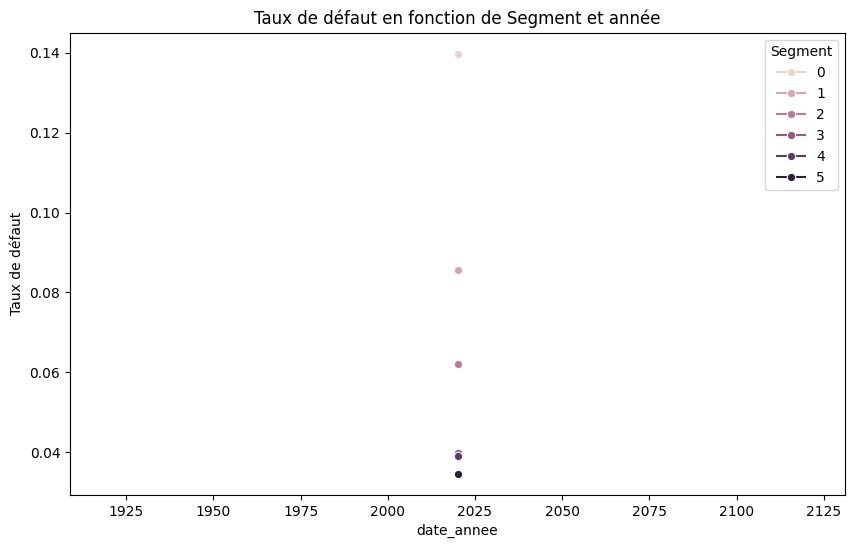

In [14]:
show_risk_stability_overtime(out_of_sample_data, "Segment")

In [13]:
show_risk_stability_overtime_2(out_of_sample_data, "Segment")